# Introduction
In the following I want to deal with the legendary Titanic Disaster Survival Challenge which has become one of the standard projects for newcomers to Data Science and Machine Learning. 
Having an own project to start with is a wonderful way of diving into Machine Learning and building a deeper knowledge and understanding. 
<br>
The ultimate goal of the challenge is to predict the survival of Titanic passengers. 
<br>
The notebook follows the basic framework for tackling a Machine Learning project:
* Import necessary Python Libaries
* Load and explore the data
* Analyse the data
* Select and clean the data
* Enhance existing features and engineer new features
* Apply a Machine Learnng model
* Train and test the model


# Import libaries

In [1]:
# Import libaries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import missingno as msno
import matplotlib.pyplot as plt # plot graphs
import seaborn as sns # plot graphs
from sklearn import preprocessing

import os # read files
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Random forest model
from sklearn.ensemble import RandomForestClassifier
        
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
print('-'*25)

/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv
-------------------------


# **Load and explore data**

<br>
Let's get startet with the dataset. 
<br>
Usally this means loading the data and storing it to a structured variable (in our case a Pandas dataframe).
<br>
The head()-method is useful to quickly examine the first few rows of the data.

In [2]:
# Load train data and display first 5 lines
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.head(5) # show first 5 rows

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Load test data and display first 5 lines
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.head(5) # show first 5 rows

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
# Save datasets in dictionary
data_dict = {}
data_dict['train data'] = train_data
data_dict['test data']  = test_data;
#data_dict['train data'] 

In [5]:
# Shape of train data
train_data.shape

(891, 12)

The training data consists of 12 features (= columns) and totally 891 samples. We can also observe that the features have different data types and that there are some missing values (e.g. non-null count is below 891)

In [6]:
# Basic info train data
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Let's look at the definition of each features and have some quick thoughts on how to use the data in the further process:

* **PassengerId**: Unique identification of the passenger. Should be included in the submission file. Not necessary for the ML alogrithm.
* **Survived**: Binary variable containing status of survival (key: 0: deceased, 1: survived). Target variable for our prediction model.
* **Pclass**: Ticket class (key: 1 = First, 2 = Second, 3 = Third), a proxy for socio-economic status. Integer encoded. The integer values have a natural ordered relationship between each other (corresponding to the ticket classes). A ML algorithm may be able to understand this relationship. Ready to use!
* **Name**: Name of the passenger. We can extract the title information and generate another feature for socio-economic status.
* **Sex**: Categorical data on the gender of a passenger (i.e. values: male, female). Should be one-hot-encoded for the ML algorithm.
* **Age**. Age in years. Can be categorized into different age intervals.
* **SibSp**. Number of siblings (brother, sister, stepbrother, stepsister) / Spouses (husband, wife, no mistresses and finances) aboard the Titanic. Gives relationhip between size of family traveled with and survival.
* **Parch**. Number of parents (mother, father) / Children (daughter, son, stepdaughter, stepson) aboard the Titanic. Gives relationhip between size of family traveled with and survival.
* **Ticket**. Ticket number. Proper use has to be investigated further.
* **Fare**. Passenger fare. Another proxy for socio-economic status. Similar to Pclass.
* **Cabin**. Cabin number. Seems to have a lot of "NaNs". Proper use has to be investigated further.
* **Embarked**. Categorical feature describing the port of embarkation (key: C = Cherbourg, Q = Queenstown, S = Southampton). Should be one-hot encoded.

In [7]:
# Shape of test data
test_data.shape

(418, 11)

The test data consists of 11 features as the taget varible "Survived" is missing from the dataset. In the following we want to train our ML algorithm so that the survival attribute is estimated from the feature input. We have 481 entries and also some missing values.

In [8]:
# Basic info train data
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


# **Analyse the data**

**Correlation of numerical values**
<br>
A heatmap is a quick method to get started with the data analysis. It shows us the correlation between the numerical values.

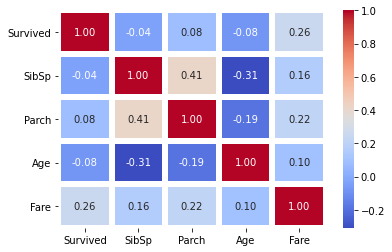

In [9]:
# Create heatmao from numerical features of train data
corr_numeric = sns.heatmap(train_data[["Survived","SibSp","Parch","Age","Fare"]].corr(),
                           annot=True, fmt = ".2f", cmap = "coolwarm", linewidths=5)

**Key takeaway**: The correlation of the numerical features with the target variable **'Survived'** is generally not too high (**highest absolute value: Fare-Survived: 0.26**). Nevertheless, all the features might be helpful in some way for prediction since there is a correlation.
<br>
<br>
Let's dive deeper into the data. The Pandas data frame provides some useful methods to quicky generate some insights from the data. We define a function to compare the data:

In [10]:
## From https://www.kaggle.com/kpacocha/top-5-titanic-machine-learning-from-disaster
    
def compare_features(data,var_1, var_2):
    return data[[var_1, var_2]][data[var_2].isnull()==False].groupby([var_1], 
                 as_index=False).mean().sort_values(by=var_2, ascending=False)
    
def plot(data,var_1, var_2):
    graph = sns.FacetGrid(data, col=var_2).map(sns.distplot, var_1)
    
def counting_values(data, var_1, var_2):
    return data[[var_1, var_2]][data[var_2].isnull()==False].groupby([var_1], 
           as_index=False)

**Correlation between Survival, Sex and Passenger Class**:
<br>
From historic records we know that the suvrival rate among men was much lower than among women. Below we can seee that the data set confirms this assertion: 78% of all women survived, whereas only 19% of men did.

In [11]:
compare_features(train_data, 'Sex','Survived')

,Sex,Survived
0,female,0.742038
1,male,0.188908


As expected, the chances of survival where the highest in the First Class, where almost 2/3 survived - which is almost 3 times as high as in the Third Class. The passengers of the First Class where more likely to get a seat in a lifeboat, since they were the first to be evacuated and their cabins were located close to the lifeboats.

In [12]:
compare_features(train_data, 'Pclass','Survived')

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In order to to examine the correlation between the target variable and the other two variables at the same time (i.e. how survival rate was affected by 'Pclass 'and 'Sex') we can use a 'Pointplot'.

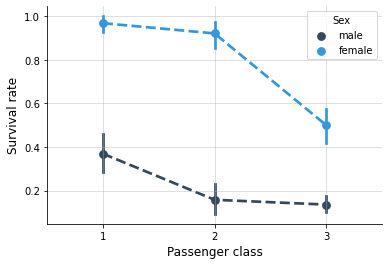

In [13]:
# Create Pointplot with Pclass, Survived, Sex:
ax = sns.pointplot(x="Pclass", y="Survived", hue="Sex",
                   data=train_data, size=5,
                   markers=["o", "o"], # Define marker shape
                   linestyles=["--", "--"], # Define linestyle
                   palette={"male": "#34495e", "female": "#3498db"}, # Custom 2- value color palette
                   )

ax = plt.gca() # Get current axis (gca)

# Insert grid
plt.grid(True, alpha=0.5)

# Remove top and left spines:
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Name axis
plt.ylabel("Survival rate", fontsize=12)
plt.xlabel("Passenger class", fontsize=12);

From the plot above we can see that the survival rates of women were in all passenger classes much higher than these of men. We also observe how the survival rate is declining from First to Third Class within men and women.
<br>
<br>
**Key takeaways:**
* Still, a woman in the Third Class was more likely to survive (ca. 50%) than a man in the First Class (ca. 35%). 
* Chances of survival were cut in the half for men in the Second Class compared to men in the First Class. 
* For women the survival rates between First and Second Class where almost identical (First: ca. 95%, Second: ca. 90%) and only declined sharply between Second and Third Class (ca. 50%).

**What about the 'Age' factor?**
<br>
Now, let us have a look at the age distribution across the passenger classes and the correlated mean age.


In [14]:
# Get table with mean age by passenger class
compare_features(train_data, 'Pclass','Age')

,Pclass,Age
0,1,38.233441
1,2,29.877630
2,3,25.140620


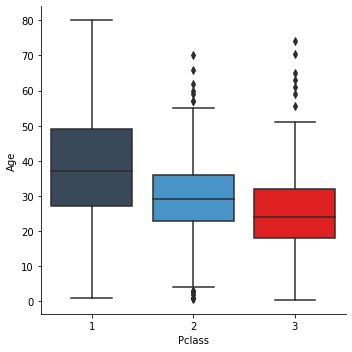

In [15]:
# Using boxplot for age and Pclass
sns.factorplot(data = train_data , x = 'Pclass' , y = 'Age', 
               kind = 'box',  palette={1: "#34495e", 2: "#3498db", 3: "r"});

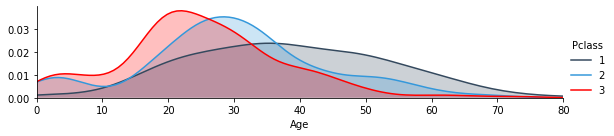

In [16]:
# Plot age distribution for all three passenger classes
g = sns.FacetGrid(train_data, hue="Pclass", size = 2, aspect=4,
                  palette={1: "#34495e", 2: "#3498db", 3: "r"})

g.map(sns.kdeplot,'Age',shade= True)
g.set(xlim=(0, train_data['Age'].max())) # Set limit to x-axis
g.add_legend()
plt.show()

**Key takeaways:**
* Most of the young people were in the Third Class. 
* The age distribution of the Second Class peaks at an older age and also has more passengers with an age between 50 and 60. 
* The First Class has a less narrow peak, i.e. forms a plateau across a much wider age span, especially in the older cohort. 
* These observations are also reflected by the mean age which is decreasing from First class (38) to Third class (25).

Now let's add the feature 'Age' as an additional dimension to our existing observation. The Seaborn class 'FacetGrid' offers a quick way of mapping multiple variables of a dataset to a grid of plots with subsets of data.

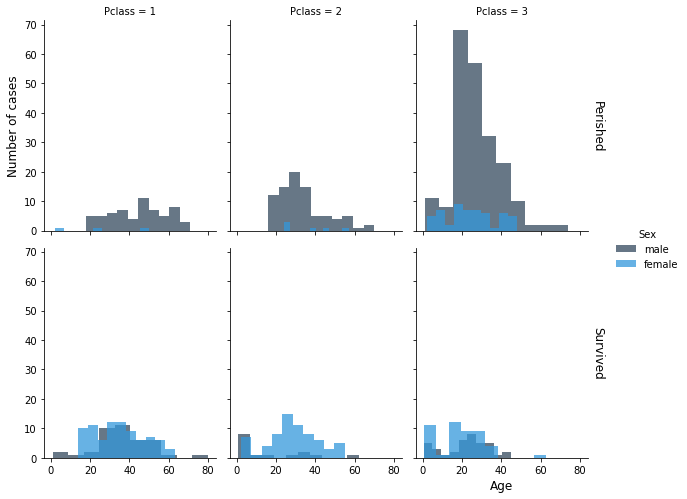

In [17]:
# Histogram comparison of sex, class, and age by survival
h = sns.FacetGrid(train_data, row = 'Survived', col = 'Pclass', hue = 'Sex', 
                  palette={"male": "#34495e", "female": "#3498db"},
                  size=3.5, aspect=0.8,
                  margin_titles=True);

h.map(plt.hist, 'Age', alpha = 0.75);

# Interate through axes
for ax in h.axes.flat:

    # Make right ylabel more human-readable and larger
    # Only the 2nd and 4th axes have something in ax.texts
    if ax.texts:
       
        txt = ax.texts[0] # Get existing right ylabel text
        survived = int(txt.get_text().split('=')[1]) # Extract survival info from text
        
        # Define new right ylabel text
        if survived == 0:
            text_new = 'Perished'
            
        elif survived == 1:
            text_new = 'Survived'
            
        # Set and format new right ylabel text 
        ax.text(txt.get_unitless_position()[0], txt.get_unitless_position()[1],
                text_new,
                transform=ax.transAxes,
                va='center',
                rotation=-90,
                fontsize=12)
        
        # Remove the original text
        ax.texts[0].remove()
        
    ax.set_xlabel(None) # Remove label from x-axis
    
# Add new labels (only y-axis top left and x-axis bottol right)
h.axes[0,0].set_ylabel('Number of cases', fontsize=12);
h.axes[1,2].set_xlabel('Age', fontsize=12);

# Add legend
h.add_legend();


**key takeaways**:
* Most of the male passengers died throughout all classes, sharply increasing with the class
* Most of the female passengers survived throughout class 1 and 2 - in class 3 still half of them survived
* The Third class had the highest amount of passengers of all classes, which were mostly men (this means also the highest absolut number of men)
* The age distribution tends to be inclined towards a younger age group with increasing class value


**Fare**
<br>
We expect that higher fare correlates with a higher passenger class and a higher rate of survival.

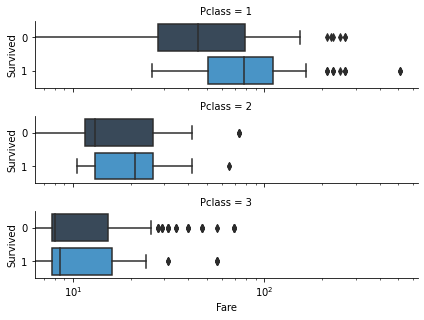

In [18]:
# Create boxplot for passenger class and fare
g = sns.catplot(x="Fare", y="Survived", row="Pclass",
                kind="box", orient="h", height=1.5, aspect=4,
                data=train_data,
                palette={0: "#34495e", 1: "#3498db"})
g.set(xscale="log");

We see that the median fare is increasing with the passenger class. We also observe that throughout all passenger classes the median fare is higher for the people who survived.

**Onboard family relations**

In [19]:
compare_features(train_data, 'SibSp', 'Survived')

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [20]:
compare_features(train_data, 'Parch', 'Survived')

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


key takeaways:
* Highest chances of survial had passengers with 1 and 2 siblings/spouses onboard the Titanic, followed by people who traveled alone (I assume that higher numbers correlate with higher logistical efforts in finding and rescuing family members and therefore higher chances of dying)
* For 'Parch' (number of children, parents onboard) the obersvation is consistent with the statement above: Smaler families had higher chances of survival ('Parch' 1, 2, 3).

**Embarked**
<br>
Port of Embarkation , C = Cherbourg, Q = Queenstown, S = Southampton. 

In [21]:
compare_features(train_data, 'Embarked', 'Survived')

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


Looks like people from Cherbourgh had a higher chance of survival. To get an idea why this was the case we can have a look at the mean age, passenger class and fare sorted by embarkment:

In [22]:
train_data.groupby(['Embarked']).mean().drop(['PassengerId', 'SibSp', 'Parch'], axis=1)

,Survived,Pclass,Age,Fare
Embarked,,,,
C,0.553571,1.886905,30.814769,59.954144
Q,0.389610,2.909091,28.089286,13.276030
S,0.336957,2.350932,29.445397,27.079812


**key takeaways**
* People from Cherbourgh had on average a higher Passenger class and therefore a higher chance of survival
* This is also reflected by the average ticket fare which is significantly higher than for the other ports.

*Note: Even though Southampton had a higher mean fare compared to Queenstown the averge passenger class was lower and also the chance of survival.*

# Select and clean the data
**Dataset Preparation**

During the preprocessing and the feature engineering process we will deduct certain metrices from the range of a variable throughout the entire dataset (e.g. data binning of age quantiles). That's why we have to concatenate the test and the training data in a single dataframe before we get startet.

In [23]:
# Quick function to combine 2 datasets:
def concat_data(data_1, data_2):
    
    return pd.concat([data_1, data_2], sort=False).reset_index(drop=True)

# Quick function to divide test and train data
def divide_data(all_data):
    
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)

# Concatenate train and test data
data_all = concat_data(train_data, test_data)
data_fs = [train_data, test_data]



<br>
Now it is time to explore in detail what is inside the dataset and assess with which data pieces we want to continue working with. A real data set normally comes with certain challenges, since often values are missing, inconsistant, invalid or are outliers.
<br>
Let's quickly get the stats for our missing data:


In [24]:
# Create infos of missing data
miss_data_dict = {}

for key, dataset in data_dict.items():
    
    # Create missing data metrices
    miss_abs = dataset.isnull().sum()
    miss_rel = miss_abs / dataset.isnull().count()

    # Write information on missing data to a structure variable
    col_abs = '{}: missing values (absolut)'.format(key)
    col_rel = '{}: missing values (relative in %)'.format(key)
    
    if key == 'test data':
        miss_data_dict[key] =  pd.concat([miss_abs.sort_values(ascending=False),
                                                  miss_rel.sort_values(ascending=False)*100], 
                                                  axis=1, keys=[col_abs, col_rel])
    elif key == 'train data':
        miss_data_dict[key] = pd.concat([miss_abs.sort_values(ascending=False),
                                                  miss_rel.sort_values(ascending=False)*100], 
                                                  axis=1, keys=[col_abs, col_rel])
        

**Missing training data**

,train data: missing values (absolut),train data: missing values (relative in %)
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467
Fare,0,0.000000
Ticket,0,0.000000


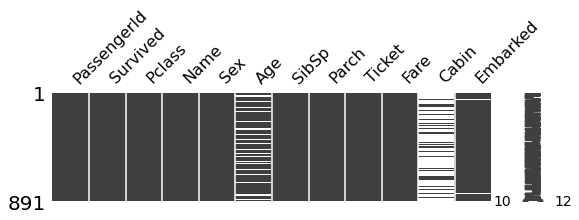

In [25]:
# Display missing train data
msno.matrix(train_data,figsize=(9,2),width_ratios=(10,1))

miss_data_dict['train data'].head()

**Missing test data**

,test data: missing values (absolut),test data: missing values (relative in %)
Cabin,327,78.229665
Age,86,20.574163
Fare,1,0.239234
Embarked,0,0.000000
Ticket,0,0.000000


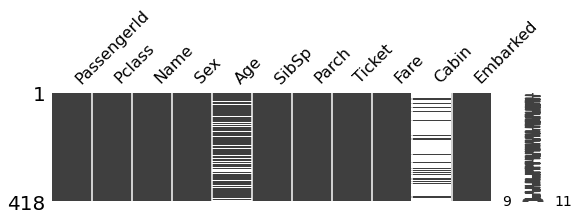

In [26]:
# Display missing test data
msno.matrix(test_data,figsize=(9,2),width_ratios=(10,1))
miss_data_dict['test data'].head()

From the figures above we can see that in both, the training and the test data, we find missing values. In both cases the most missing values we have within "Cabin" (ca. 80% missing values) and "Age" (ca. 20% missing values).
Let's see ho we can handle this.

**Missing age values**
<br>
Around 20% of the age data is missing which is a serious issue.
<br>
From the data analysis we know that the passenger's age correlates to passenger class and gender.
<br>
The graph below shows the age range within the different passenger classes. We observe that the average age increases from third to first class. This seems plausible since older people are wealthier on average than younger people.


In [27]:
# Print average age per subcategory ('Pclass' and 'Sex')
data_all.groupby(['Pclass', 'Sex'])['Age'].mean()

Pclass  Sex   
1       female    37.037594
        male      41.029272
2       female    27.499223
        male      30.815380
3       female    22.185329
        male      25.962264
Name: Age, dtype: float64

**Before**: Missing age data and corresponding passenger class, sex

In [28]:
# Get indices of NaN age data
index = data_all['Age'].index[data_all['Age'].apply(np.isnan)]

data_all.loc[index, ['Pclass', 'Sex', 'Age']]

,Pclass,Sex,Age
5,3,male,NaN
17,2,male,NaN
19,3,female,NaN
26,3,male,NaN
28,3,female,NaN
...,...,...,...
1299,3,female,NaN
1301,3,female,NaN
1304,3,male,NaN
1307,3,male,NaN


**After**: Missing age data and corresponding passenger class, sex

In [29]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [30]:
# Replace missing valuse with medium of subgroup
data_all['Age'] = data_all.groupby(['Pclass', 'Sex'])['Age'].apply(lambda x: x.fillna(x.mean()))

# Save changes to data_dict
train_data, test_data = divide_data(data_all)
data_dict['train data'] = train_data
data_dict['test data']  = test_data

data_all.loc[index, ['Pclass', 'Sex', 'Age']]

,Pclass,Sex,Age
5,3,male,25.962264
17,2,male,30.815380
19,3,female,22.185329
26,3,male,25.962264
28,3,female,22.185329
...,...,...,...
1299,3,female,22.185329
1301,3,female,22.185329
1304,3,male,25.962264
1307,3,male,25.962264


**Missing cabin values**
<br>
When it comes to the cabin value we only have data for 20% of our observations. That's why many people usually would drop this feature from the dataset. However, in the following we want to try to keep the dataset and use an approach similar to this notebook ([link](https://www.kaggle.com/kpacocha/top-5-titanic-machine-learning-from-disaster)):
* Extract the first letter which corresponds to the cabin deck
* Observe correlations between cabin deck and other features
* Chose the feature which can be best correlated to the cabin deck and replace the unknown deck entries accordingly

*Note: When you deal with the data you will observe that it is impossible to directy deduct the cabin deck from other categories. Therefore, I also tried to find some historical information which might be useful in allocating the missing deck information to the passengers. However, this turned out to be quite complexe: There is a full body of academic and non-academic sources trying to allocate the cabins on the Titanic ([link](https://www.encyclopedia-titanica.org/cabins.html)). In the consequence, I sticked to the simple approach described above.*

In [31]:
# Fill missing data with 'Unknown'
data_all.Cabin = data_all.Cabin.fillna('Unknown')

# Extract first letter form 'Cabin' and save to new feature 'Deck'
data_all['Deck'] = data_all['Cabin'].str[0]

**Passenger class and cabin deck:**

In [32]:
data_all.groupby(['Pclass']).Deck.value_counts()

Pclass  Deck
1       C        94
        U        67
        B        65
        D        40
        E        34
        A        22
        T         1
2       U       254
        F        13
        D         6
        E         4
3       U       693
        F         8
        G         5
        E         3
Name: Deck, dtype: int64

**Survival rate, mean Passenger class, Age and Fare by cabin deck:**

In [33]:
data_all.groupby(['Deck']).mean().drop(['PassengerId', 'SibSp', 'Parch'], axis=1)

,Survived,Pclass,Age,Fare
Deck,,,,
A,0.466667,1.000000,43.731264,41.244314
B,0.744681,1.000000,36.554875,122.383078
C,0.593220,1.000000,38.523094,107.926598
D,0.757576,1.130435,39.508946,53.007339
E,0.750000,1.243902,37.904051,54.564634
F,0.615385,2.380952,21.814755,18.079367
G,0.500000,3.000000,12.000000,14.205000
T,0.000000,1.000000,45.000000,35.500000
U,0.299854,2.617357,27.179009,19.132707


**Key takeaways**
<br>
* The data for the decks A, B and C consist only of First class passengers.
* Lack of cabin data comes with lower class passengers, lower fare values and lower age.
* With the exception of the First Class, the majority of the cabin data is missing

In the following, we want to replace the 'unknown' deck values by the deck which average fare is closest to the correlated fare. 



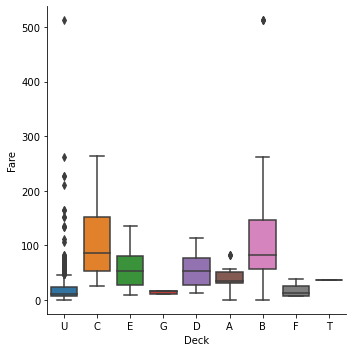

In [34]:
# Plot median fare for different decks
sns.factorplot(data = data_all , x = 'Deck' , y = 'Fare', 
               kind = 'box');

We choose to replace the missing deck information with the help of the fare data.

In [35]:
# Create list with average fare for each deck, drop category 'U'
deck_avg_fare = data_all.groupby(['Deck']).Fare.mean().drop('U')
deck_avg_fare

Deck
A     41.244314
B    122.383078
C    107.926598
D     53.007339
E     54.564634
F     18.079367
G     14.205000
T     35.500000
Name: Fare, dtype: float64

In [36]:
# Get indices with 'U' from data
indices_U = data_all[data_all['Deck'] == 'U'].index

# Loop over indices with 'U'
for i in indices_U:
    
    # Get current fare
    fare = data_all.iloc[i].Fare
    
    # Identify nearest average fare for current fare
    nearest_avg_fare = min(deck_avg_fare, key=lambda x:abs(x-fare))

    # Return deck letter for nearest average fare
    deck = deck_avg_fare[deck_avg_fare == nearest_avg_fare].index[0]
    
    # Write to deck category
    data_all['Deck'].iloc[i] = deck
    
# Save changes to data_dict
train_data, test_data = divide_data(data_all)
data_dict['train data'] = train_data
data_dict['test data']  = test_data

In [37]:
data_all.loc[indices_U, ['Fare', 'Deck']]

,Fare,Deck
0,7.2500,G
2,7.9250,G
4,8.0500,G
5,8.4583,G
7,21.0750,F
...,...,...
1303,7.7750,G
1304,8.0500,G
1306,7.2500,G
1307,8.0500,G


For the rest of the missing data we apply a simple strategy to fill in the missing data:
* **Numeric values**: Use the mean value
* **Non-numeric values**: Use the most common value

In [38]:
# Define Function for handling missing data

def handle_missing_data(data, miss_abs):
    
    for col in data:
        
        # identify proportion of missing data
        miss_prop = data[col].isna().sum()/len(data) 
        
        # Drop entire column if missing data is more than 50%
        #if miss_prop > 0.5:
            
        #    data.drop(col, axis=1, inplace=True)
            
            # Report activity
        #   print("Deleting {} since it is having {:.2f} % of missing rows.".format(col,miss_prop*100) )
        
        if  miss_prop < 0.5:
            
            # Fill missing data with mean value if missing data is numeric
            if data[col].dtype == "float64" and data[col].isnull().sum() > 0:
            
                # Calculate mean
                mean = data[col].mean()
            
                # Fill missing data with mean value
                data[col] = data[col].fillna(mean)
                
                # Report activity
                print("Filling {} missing values in {} with mean value {:.0f}.".format(miss_abs[col], col, mean) )
            
            # Fill missing data with most common value if missing data is non-numeric
            elif data[col].dtype == "object" and data[col].isnull().sum() > 0:
                
                # Get top value (most common)
                top = data[col].describe().top
                
                # Fill missing data with top value
                data[col] = data[col].fillna(top)
                
                # Report activity
                print("Filling {} missing values in {} with top value {}.".format(miss_abs[col], col, top) )
            
    return data

In [39]:
#train_data = pd.read_csv("/kaggle/input/titanic/train.csv")


for key, dataset in data_dict.items():
    
    print('{} operations:'.format(key))
    
    miss_abs = miss_data_dict[key]['{}: missing values (absolut)'.format(key)] 
    miss_rel = miss_data_dict[key]['{}: missing values (relative in %)'.format(key)]
    
    data_dict[key] = handle_missing_data(dataset, miss_abs)

train data operations:
Filling 2 missing values in Embarked with top value S.
test data operations:
Filling 1 missing values in Fare with mean value 36.


Now there are no missing values left in our dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    float64
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        891 non-null    object 
 11  Embarked     891 non-null    object 
 12  Deck         891 non-null    object 
dtypes: float64(3), int64(4), object(6)
memory usage: 90.6+ KB


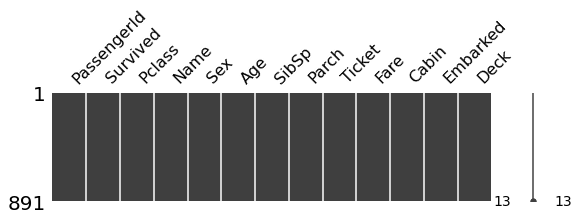

In [40]:
msno.matrix(train_data,figsize=(9,2),width_ratios=(10,1))
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 891 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          418 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         418 non-null    float64
 9   Cabin        418 non-null    object 
 10  Embarked     418 non-null    object 
 11  Deck         418 non-null    object 
dtypes: float64(2), int64(4), object(6)
memory usage: 39.3+ KB


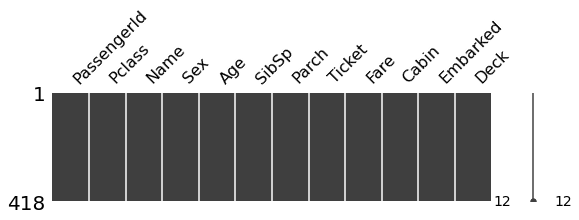

In [41]:
msno.matrix(test_data,figsize=(9,2),width_ratios=(10,1))
test_data.info()

# Enhance existing features and engineer new features
Feature engineering is "*the process of using domain knowledge to extract features from raw data via data mining techniques*" ([Wikipedia](https://en.wikipedia.org/wiki/Feature_engineering)).
<br>
In other words, with feature engineering we create the "**essence**" from which our machine learning algorithms will learn from later on in the training process and consequently influence the accuracy of our model predictions. Therefore, feature engineering is a crucial step in the machine learning workflow and also an creative art that will seperate good from bad models.
<br>
The Titanic dataset offers a lot of exicting possibilities for feature engineering to play around with, especially since there are a lot of historical records and side information available on the Internet (this is our so called "domain knowledge" in the Data Science, Machine Learning context). You can find a huge huge body of creative Notebooks showing the full range of possible methods. In the following I tried out some of them and also combined different approaches. 
<br>
The following Notebooks were my primary source of inspiration:
* [Kaggl Titanic: A Machine Learning from Disaster | Feature Eng. Part 1](https://www.codementor.io/@innat_2k14/titanic-kaggle-machine-learning-from-disaster-part-1-10gbvqzguc)
* [Machine Learning with the Titanic Dataset](https://towardsdatascience.com/machine-learning-with-the-titanic-dataset-7f6909e58280)
* [Titanic Dataset - Zero to Hero (within Top 3%)](https://www.kaggle.com/darkknight98/titanic-dataset-zero-to-hero-within-top-3)
* [Predicting the Survival of Titanic Passengers](https://towardsdatascience.com/predicting-the-survival-of-titanic-passengers-30870ccc7e8)

<br>



**Extract "Title"**
<br>
The title of a passenger can be used as a proxy for socio-economic status and hence correlates with the chances of survival of a person. We can find the title information in the "Name" column of our dataset and extract the relevant pieces of information with "split" (we make use of the fact that in every name string there is a '**,**' before and a '**.**' after the title information ;-)).


In [42]:
# Accessing title data from 'Name' column
data_all['Name'].str.split(',', expand=True)[1].str.split('.', expand=True)[0]

0            Mr
1           Mrs
2          Miss
3           Mrs
4            Mr
         ...   
1304         Mr
1305       Dona
1306         Mr
1307         Mr
1308     Master
Name: 0, Length: 1309, dtype: object

In [43]:
# Define a function for extracting the title
def title_extract(data):
    
    data['Title'] = data['Name'].str.split(',', expand=True)[1].str.split('.', expand=True)[0]

In [44]:
# Apply title extraction function to the dataset
for key, dataset in data_dict.items():
    title = title_extract(dataset)
    
data_all = concat_data(train_data, test_data)

# Display title value count within training data
data_all['Title'].value_counts()

 Mr              757
 Miss            260
 Mrs             197
 Master           61
 Rev               8
 Dr                8
 Col               4
 Ms                2
 Mlle              2
 Major             2
 Capt              1
 Mme               1
 Sir               1
 Lady              1
 Jonkheer          1
 Don               1
 Dona              1
 the Countess      1
Name: Title, dtype: int64

**Mapping table**
<br>
In the table above we see the title distribution across the entire dataset.
<br>
From the title we can deduct information about gender ("Mr", "Miss", "Mrs", "Mme" etc.), martial status ("Miss", "Ms" etc.) and education / profession (e.g. social-economic status, "Master", "Dr", "Major" etc.). 
<br>
We can observe that the majority of titles in the dataset are "Mr", "Miss", "Mrs" and "Master" and therefore proceed with the following title bins:

* **Mr**
* **Mrs**
* **Miss**
* **Master**
* **Misc** (if title count is < 10)

In [45]:
# Assess (in full dataset) whether a title is rare (True if rare)
title_names = (data_all['Title'].value_counts() <  10)

for key, dataset in data_dict.items():

    # Replace titles with 'Misc' if they are rare (= value in title_names = True)
    ## Code from: https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy
    dataset['Title'] = dataset['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)

data_all = concat_data(train_data, test_data)

print(data_all['Title'].value_counts())

 Mr        757
 Miss      260
 Mrs       197
 Master     61
Misc        34
Name: Title, dtype: int64


**Data binning for feature "Age"**

**Data binning or bucketing** means that we split up the original data into smaller chunks known as bins. The values within each bin are then replaced by a general value calculated for each bin, e.g. we change the original continous data values to discrete bins (in this case: age intervals).
<br>
This process minimizes the effects of small observation errors, outliers and "smoothes" the data. 
<br>
There are different approaches for creating the bins. We can either directly define them or we can use the Pandas method "[cut](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html)" to define the bins based on the value range of the data.

In [46]:
print('Maximum age in train & test data: ', data_all['Age'].max() )
print('Minimum age in train & test data: ', data_all['Age'].min() )

Maximum age in train & test data:  80.0
Minimum age in train & test data:  0.17


We specify 5 as the number of equal-sized intervals within the range of "Age". This creates 5 bins with an equal size of 16 years from the age range of the dataset (0 - 80 years).
<br>
Instead of creating an interval with explicit numbers, we can also map the age data directly to a numerical category (see column "Age group"). For better interpretation, we keep the "Age interval" column in the dataset.

In [47]:
for key, dataset in data_dict.items():
    
    # Convert age data to integer
    dataset['Age'] = dataset['Age'].astype('int', copy=True)
    
    # Define labels for age group
    age_labels = [1,2,3,4,5]
    
    ## Split the data into 5 chunks of equals size within the range of Age 
    ## (entire dataset as basis!)
    
    # Intervals:
    dataset['Age interval'] = pd.cut(data_all['Age'].astype('int'),5)
    
    # Label intervals with number (integers):
    dataset['Age Code']     = pd.cut(data_all['Age'],5, labels=age_labels).astype('int64')
    
data_all = concat_data(train_data, test_data)
    
print('Number of cases within age intervals in datast:')
data_all['Age interval'].value_counts()

Number of cases within age intervals in datast:


(16.0, 32.0]     752
(32.0, 48.0]     304
(-0.08, 16.0]    134
(48.0, 64.0]     106
(64.0, 80.0]      13
Name: Age interval, dtype: int64

**Data Binning for feature "Fare"**
<br>
For the feature "Fare" we use the Pandas method "[qcut](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.qcut.html)" which splits a distribution into categories with the same number of cases (e.g. quantile-based discretization function) - in contrast to "cut" which creates equal-sized bins based on the range of the variable.

In [48]:
for key, dataset in data_dict.items():
    
    # Define labels for age group
    fare_labels = [1,2,3,4,5]
    
    ## Split the data into 5 chunks of equals number of values 
    ## (entire dataset as basis!):
    
    # Intervals:
    dataset['Fare interval'] = pd.qcut( data_all['Fare'], 5 )
    
    # Label intervals with number (integers):
    dataset['Fare Code'] = pd.qcut( data_all['Fare'], 5, labels=fare_labels).astype('int64')

data_all = concat_data(train_data, test_data)

print('Number of cases per fare category in dataset (approx. equal):')
data_all['Fare interval'].value_counts()

Number of cases per fare category in dataset (approx. equal):


(-0.001, 7.854]      275
(21.679, 41.579]     263
(41.579, 512.329]    259
(10.5, 21.679]       258
(7.854, 10.5]        254
Name: Fare interval, dtype: int64

**Create new feature "family size"**
<br>
"**SibSp**" defines the number of siblings and spouses, "**Parch**" includes the number of parents and childrens of a passenger abord the Titanic. Like in many other "Titanic" notebooks we summarize this information into the variable "Family Size" which includes +1 for the passenger.

In [49]:
for key, dataset in data_dict.items():
    
    dataset['Family Size'] = dataset ['SibSp'] + dataset['Parch'] + 1                                                                

data_all = concat_data(train_data, test_data)

1     790
2     235
3     159
4      43
6      25
5      22
7      16
11     11
8       8
Name: Family Size, dtype: int64

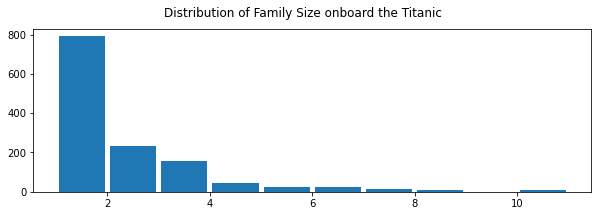

In [50]:
max_family = dataset['Family Size'].max()
min_family = dataset['Family Size'].min()

x = data_all['Family Size'].hist(bins=max_family-1, grid=False, figsize=(10,3),  zorder=2, rwidth=0.9);

ax = plt.suptitle('Distribution of Family Size onboard the Titanic');
data_all['Family Size'].value_counts()

In [51]:
# Define family size mapping via lambda function
family_mapping = (lambda s: 1 if s == 1 else (2 if s == 2 else (3 if 3 <= s <= 4 else (4 if s >= 5 else 0))))

for key, dataset in data_dict.items():
    
    dataset['Family Size Code'] = dataset['Family Size'].map(family_mapping)
    
# data_all['Family Size categories'] = data_all['Family Size'].map(family_mapping)
data_all = concat_data(train_data, test_data)
data_all['Family Size Code'].value_counts()

1    790
2    235
3    202
4     82
Name: Family Size Code, dtype: int64

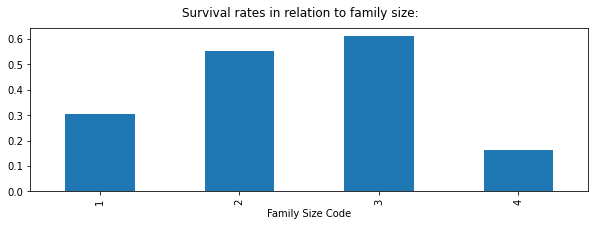

In [52]:
data_all[ ['Family Size Code', 'Survived'] ].groupby('Family Size Code')['Survived'].mean().plot(kind='bar', figsize=(10,3))
ax = plt.suptitle('Survival rates in relation to family size:');

**Create new feature 'Mother'**
<br>
We create the new feature 'Mother* which is defined by the following criteria: Women with 'Mrs' title and at least 1 parch.

In [53]:
for key, dataset in data_dict.items():
    
    dataset['Mother'] = np.where((dataset.Title == 'Mrs') & (dataset.Parch >0),1,0)    

data_all = concat_data(train_data, test_data)

**Create new feature 'Ticket frequency'**
<br>
Let's filter for identical ticket numbers to get an indication who travelled together and create a new feature from this.

In [54]:
for key, dataset in data_dict.items():

    dataset['Ticket Frequency'] = data_all.groupby('Ticket')['Ticket'].transform('count')
    
data_all = concat_data(train_data, test_data)

In [55]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Deck,Title,Age interval,Age Code,Fare interval,Fare Code,Family Size,Family Size Code,Mother,Ticket Frequency
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,...,G,Mr,"(16.0, 32.0]",2,"(-0.001, 7.854]",1,2,2,0,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,...,C,Mrs,"(32.0, 48.0]",3,"(41.579, 512.329]",5,2,2,0,2
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,...,G,Miss,"(16.0, 32.0]",2,"(7.854, 10.5]",2,1,1,0,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,...,C,Mrs,"(32.0, 48.0]",3,"(41.579, 512.329]",5,2,2,0,2
4,5,0.0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,...,G,Mr,"(32.0, 48.0]",3,"(7.854, 10.5]",2,1,1,0,1


# Apply a Machine Learnng model
Let's collect the features we want to use for the model:

In [56]:
# Collect features
features = ['Sex', 'Age Code', 'SibSp', 'Parch', 'Mother', 'Family Size Code',
            'Pclass', 'Fare Code', 'Embarked', 'Fare', 'Deck',
            'Title', 'Ticket Frequency']


print(data_all[features].info())
data_all[features].head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Sex               1309 non-null   object 
 1   Age Code          1309 non-null   int64  
 2   SibSp             1309 non-null   int64  
 3   Parch             1309 non-null   int64  
 4   Mother            1309 non-null   int64  
 5   Family Size Code  1309 non-null   int64  
 6   Pclass            1309 non-null   int64  
 7   Fare Code         1309 non-null   int64  
 8   Embarked          1309 non-null   object 
 9   Fare              1309 non-null   float64
 10  Deck              1309 non-null   object 
 11  Title             1309 non-null   object 
 12  Ticket Frequency  1309 non-null   int64  
dtypes: float64(1), int64(8), object(4)
memory usage: 133.1+ KB
None


,Sex,Age Code,SibSp,Parch,Mother,Family Size Code,Pclass,Fare Code,Embarked,Fare,Deck,Title,Ticket Frequency
0,male,2,1,0,0,2,3,1,S,7.2500,G,Mr,1
1,female,3,1,0,0,2,1,5,C,71.2833,C,Mrs,2
2,female,2,0,0,0,1,3,2,S,7.9250,G,Miss,1
3,female,3,1,0,0,2,1,5,S,53.1000,C,Mrs,2
4,male,3,0,0,0,1,3,2,S,8.0500,G,Mr,1


**Make data readable for Machine Learning**
<br>
Before we can feed our dataset into a Machine Learning algorithm we have to make sure that we only have numerical inputs since many algorithms cannot interprete non-numerical values.
<br>
This means that we have to convert the categorical variables into numerical ones.
There are basically two approaches depending on the type of categorical variable:
* **Ordinal data**: There is a logical order, i.e. rank order (*e.g. Pclass - first class, second class, third class*) between the values. Here, we use label encoding which means we replace the category names by integer values. This has already been realized in the dataset!
* **Nominal data**: There is no specific numerical value or meaning in the data and it therefore cannot be ranked (*e.g. Sex - male, female; Embarkment - S, C, Q; Title - Mr, Mrs, Miss, Misc etc.*). In this case, we use one-hot encoding to make the data 'machine readable',

In [57]:
# Get dummy code for nominal features
# (function 'get_dummies' just affets the variables with dtype 'object')
X_train = pd.get_dummies(train_data[features])
X_test  = pd.get_dummies(test_data[ features])

X_test.head()

,Age Code,SibSp,Parch,Mother,Family Size Code,Pclass,Fare Code,Fare,Ticket Frequency,Sex_female,...,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Title_ Master,Title_ Miss,Title_ Mr,Title_ Mrs,Title_Misc
891,3,0,0,0,1,3,1,7.8292,1,0,...,0,0,0,1,0,0,0,1,0,0
892,3,1,0,0,2,3,1,7.0000,1,1,...,0,0,0,1,0,0,0,0,1,0
893,4,0,0,0,1,2,2,9.6875,1,0,...,0,0,0,1,0,0,0,1,0,0
894,2,0,0,0,1,3,2,8.6625,1,0,...,0,0,0,1,0,0,0,1,0,0
895,2,1,1,0,3,3,3,12.2875,2,1,...,0,0,0,1,0,0,0,0,1,0


In [58]:
# Get target variable 'Survived'
y = train_data['Survived']

In [59]:
# Define model
#model = RandomForestClassifier(n_estimators=60,max_depth=5,random_state=1)

model = RandomForestClassifier(n_estimators=1800,
                               max_depth=8,
                               min_samples_split=6,
                               min_samples_leaf=6,
                               max_features='auto',
                               oob_score=True,
                               random_state=42,
                               n_jobs=-1,
                               verbose=1)


# Fit model to train data "survived"
model.fit(X_train, y)

# Get predictions
predictions = model.predict(X_test)

#model.score(X,y)
acc_random_forest = round(model.score(X_train, y) * 100, 2)
print(acc_random_forest)


# Compile prediction with PassengerID into data frame
output = pd.DataFrame({'PassengerID': test_data.PassengerId, 'Survived': predictions})

output = output.convert_dtypes() # also convert output to int!

# Write data frame with predition to csv file
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

output.head()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:    4.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Do

85.3
Your submission was successfully saved!


,PassengerID,Survived
891,892,0
892,893,1
893,894,0
894,895,0
895,896,1
